In [20]:
import plotter # plotting functions
import importlib
importlib.reload(plotter)
from plotter import *
import warnings
warnings.filterwarnings('ignore') # for the purpouse of plotting in the notebook

__1) Center Of Gravity Placement Range__

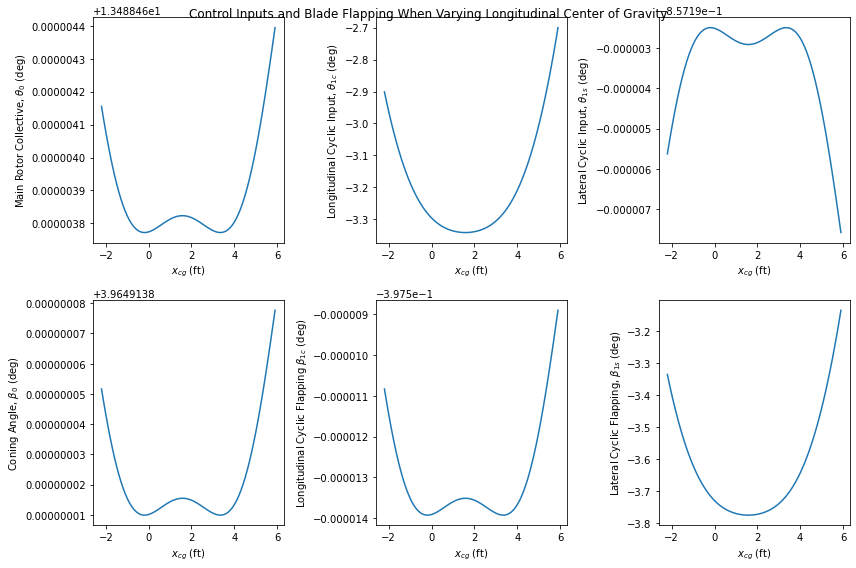

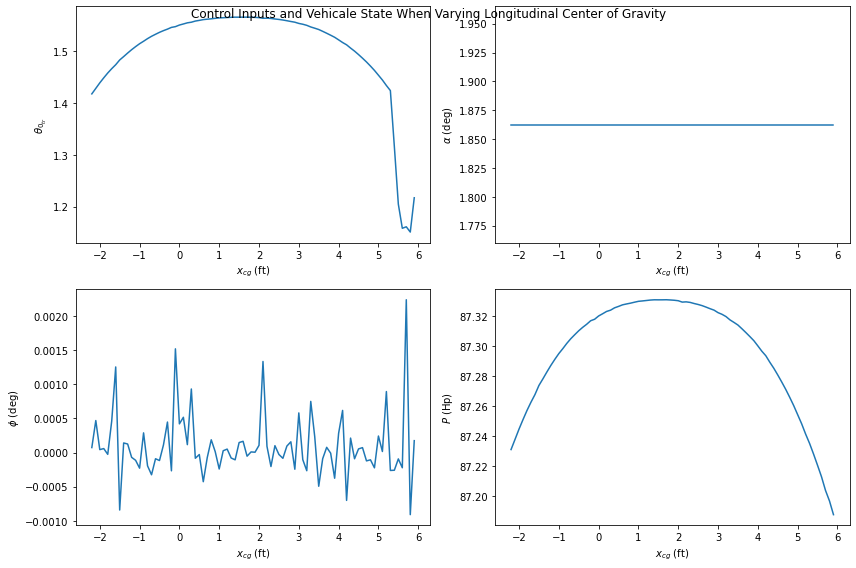

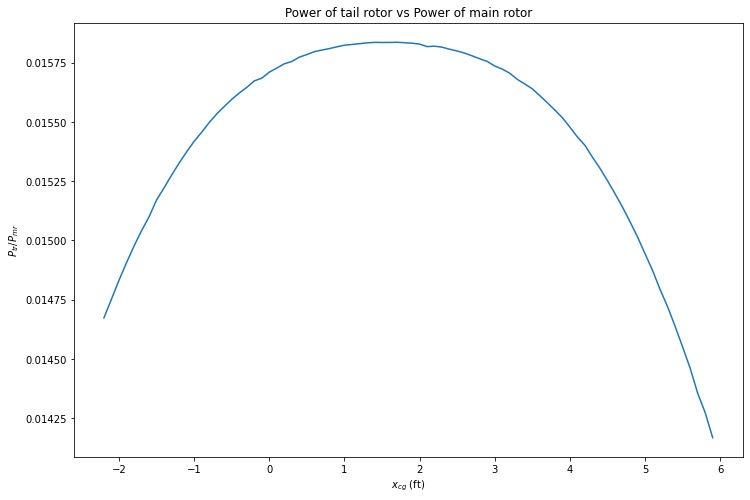

In [13]:
vary_xcg()

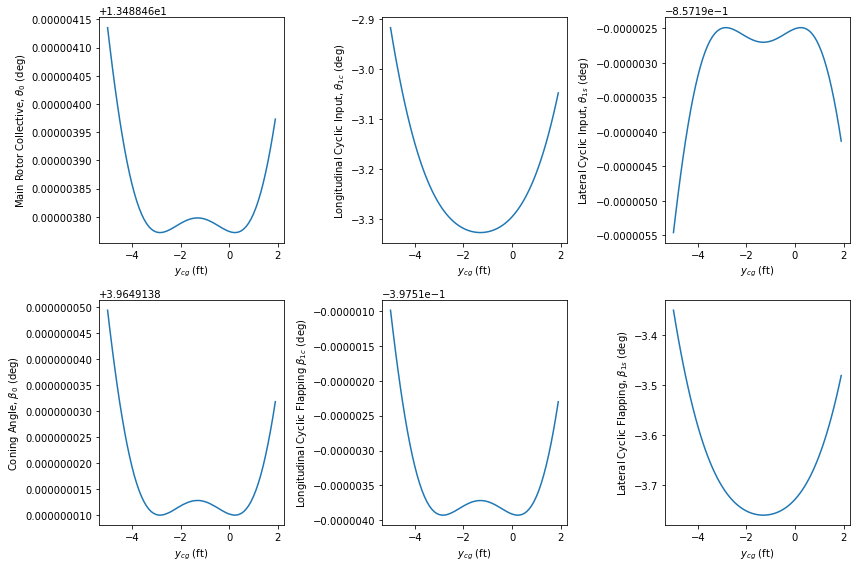

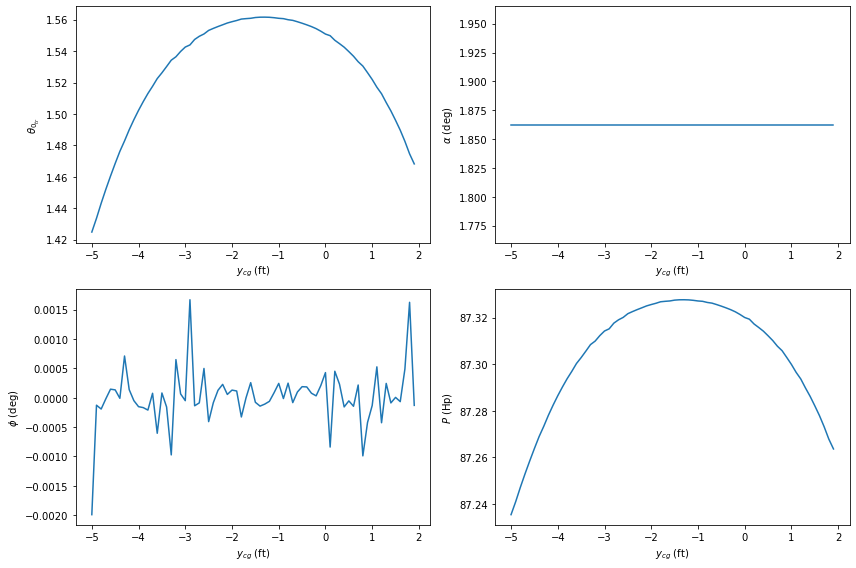

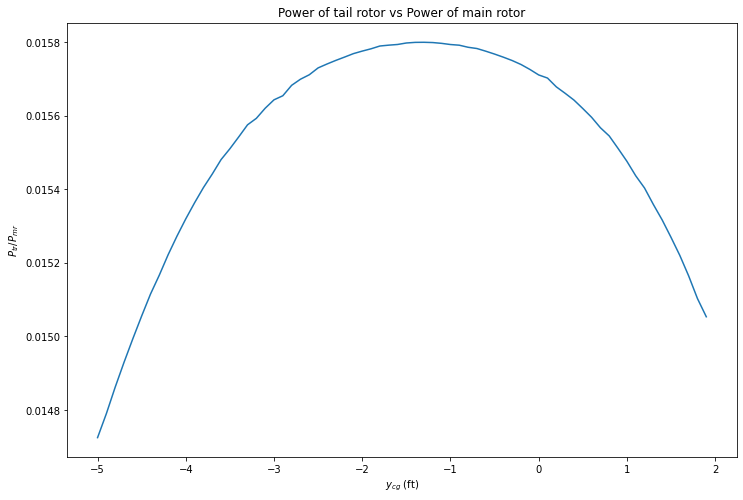

In [14]:
vary_ycg()

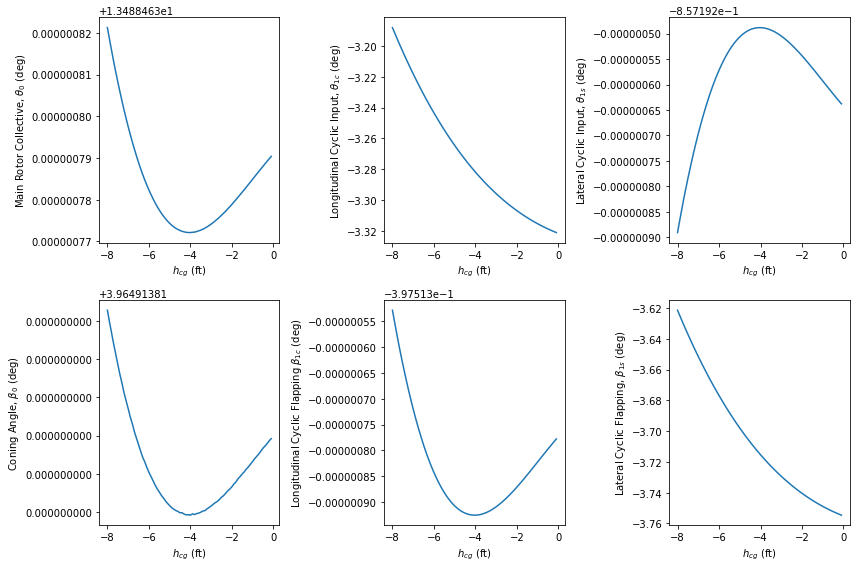

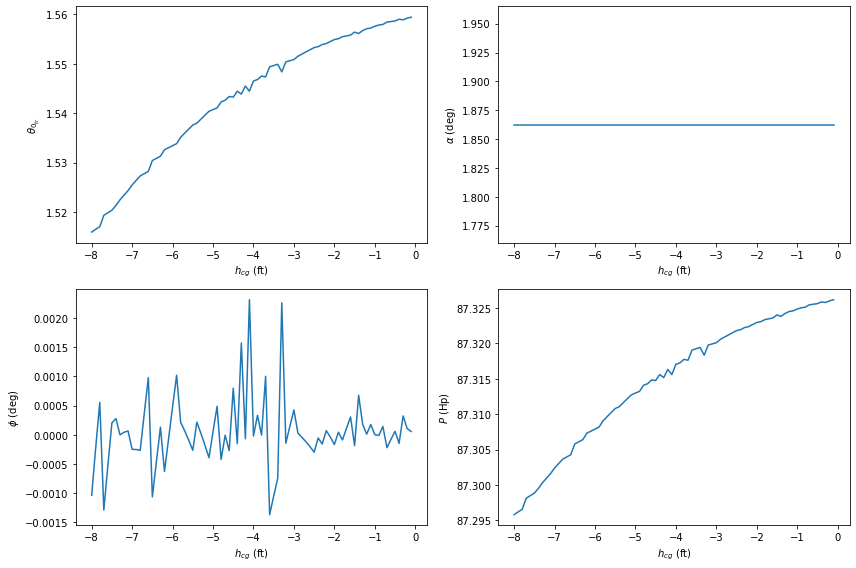

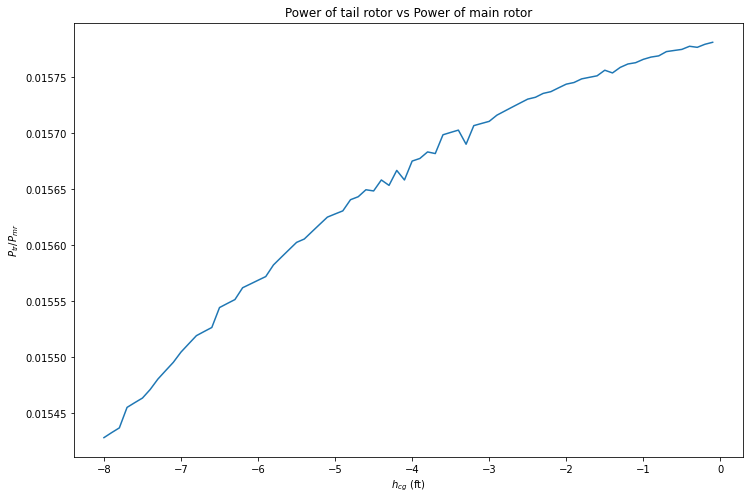

In [15]:
vary_hcg()

__2) Varying Tail Empenage Parameters__

__Varying Tail Empenage Span__

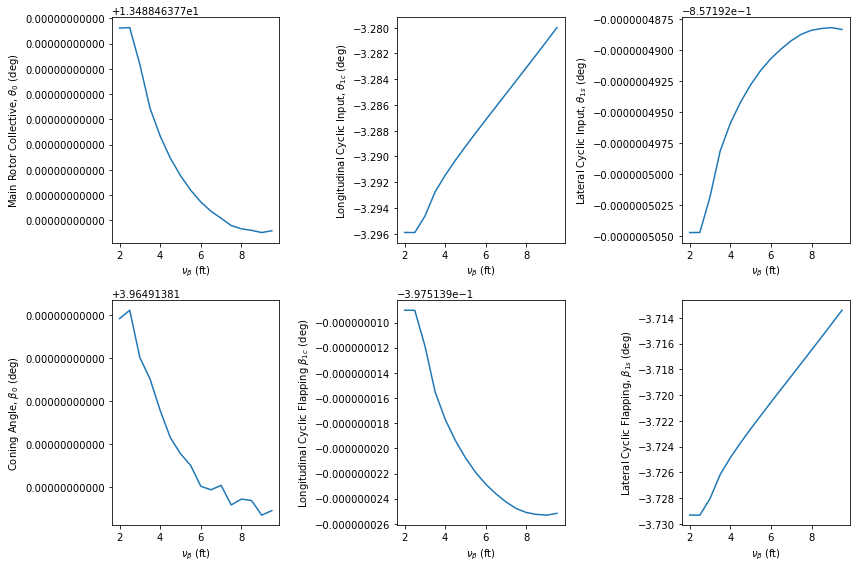

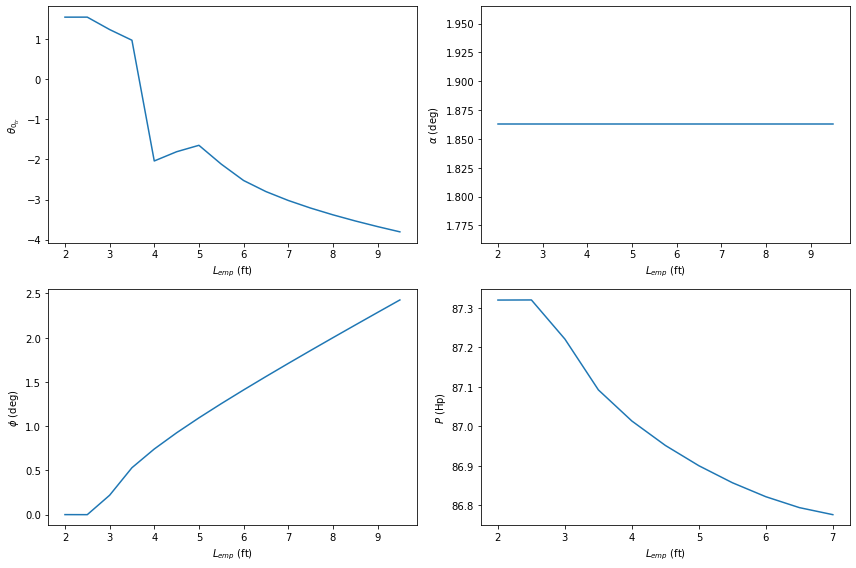

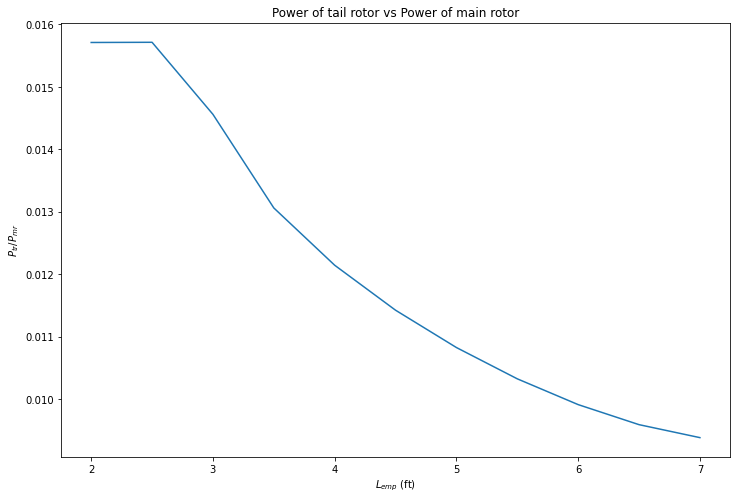

In [21]:
vary_L_emp()

__Varying Tail Empenage Incidence Angle (with the longitudinal axis)__

__Varying Tail Empenage Longitudinal Position__

__4) Blade Flapping Frequency Sensitivity__

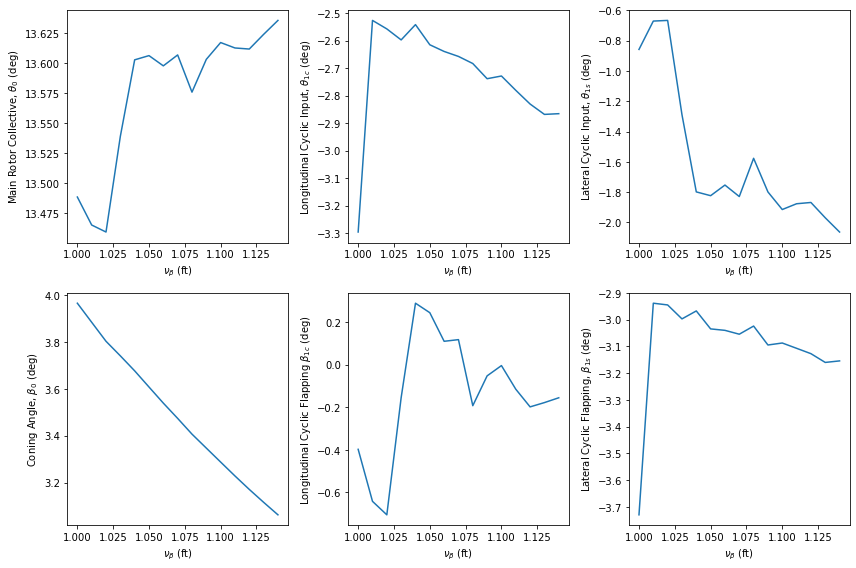

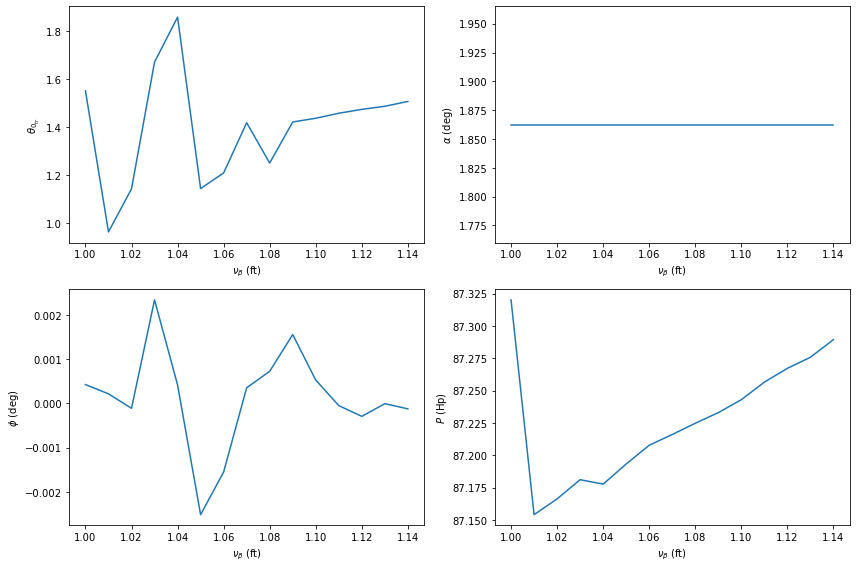

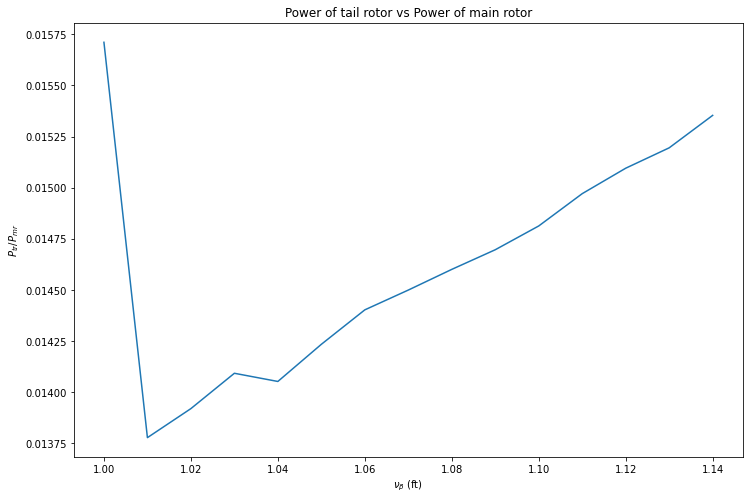

In [16]:
vary_nu_beta()